# ***Latent Semantic Analysis: Machine Learning***
### Goals:
* Pull data from MongoDB
* TFIDF data
* Write function that uses LSA to search the pages and find the top 5 articles relating to a given search query

### Output:
* Top 5 articles that relate to search query

## 1. Load Data from MongoDB
* Remove duplicates

In [1]:
cd ..

/home/jovyan/dsi/assignments/p4


In [2]:
%run __init__.py

In [3]:
%matplotlib inline

In [4]:
client = pymongo.MongoClient('34.215.225.199', 27016)
db_ref = client.wiki_database
wiki_ref = db_ref.wiki_database

In [5]:
wiki_data = []
cursor = wiki_ref.find({})
for document in cursor:
    wiki_data.append(document)

In [6]:
wiki_df = pd.DataFrame(wiki_data)
wiki_df.drop_duplicates(subset=['pageid'], inplace=True)
wiki_df.head(10)

,_id,category,pageid,text
0,5a1506d02c74b40013488ead,Machine learning,43385931,multiple issuesrefimprovedatejuly footnotesdat...
1,5a1506d22c74b40013488eae,Machine learning,49082762,use dmy datesdateseptember machine learn barth...
2,5a1506d42c74b40013488eaf,Machine learning,233488,forthe journalmachine learn journalmachine lea...
3,5a1506d52c74b40013488eb0,Machine learning,53587467,attention outline set outline list portalconte...
4,5a1506d62c74b40013488eb1,Machine learning,3771060,accuracy paradox predictive analytic state pre...
5,5a1506d72c74b40013488eb2,Machine learning,43808044,machine learn baraction model learning abbrevi...
6,5a1506d82c74b40013488eb3,Machine learning,28801798,abouta machine learn methodactive learning con...
7,5a1506d82c74b40013488eb4,Machine learning,45049676,adversarial machine learning research field li...
8,5a1506d92c74b40013488eb5,Machine learning,52642349,infobox artist aiva nationality luxembourgish ...
9,5a1506da2c74b40013488eb6,Machine learning,30511763,multiple issuescoidatenovember expert neededwi...


## 2. TFIDF

In [7]:
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,3))
X_tf = tfidf.fit_transform(wiki_df['text'])

In [8]:
doc_term_matrix_df = pd.DataFrame(X_tf.toarray(),
                                  index=wiki_df.index,
                                  columns=tfidf.get_feature_names())

In [9]:
doc_term_matrix_df.shape

(2665, 12001)

#### Plots to show the top 30 words

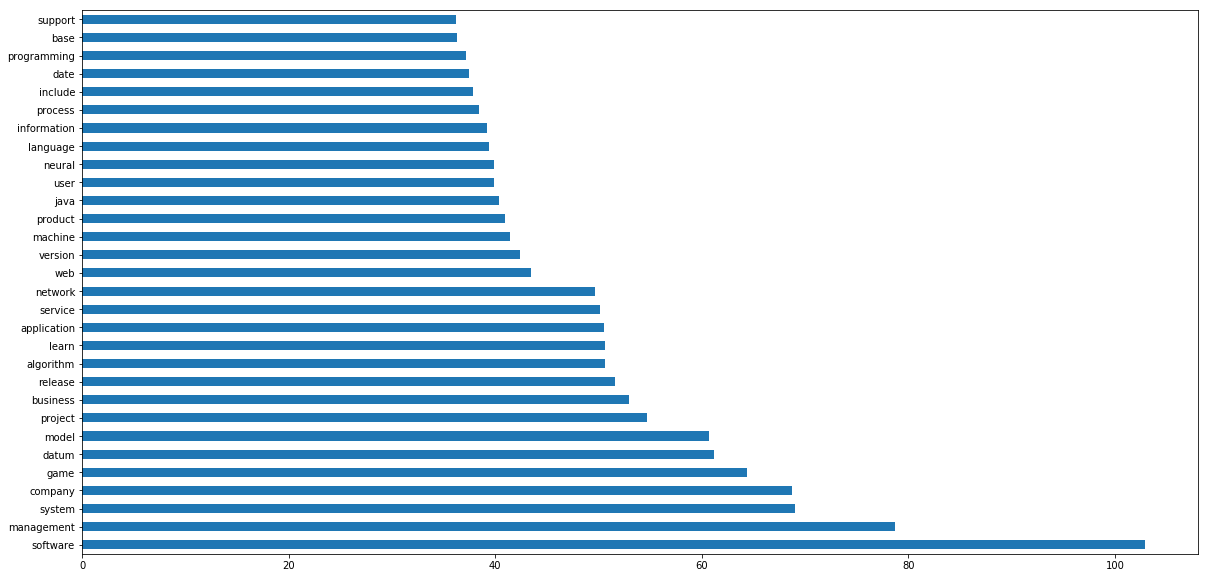

In [10]:
fig = plt.figure(figsize=(20,10))
_ = doc_term_matrix_df.sum(axis=0).sort_values(ascending=False)[:30].plot.barh()
# plt.savefig('./figures/top_30_words.png')
# plt.savefig('./figures/top_30_words.pdf')

## 3. Search
* Using LSA and cosine similarity to find the most similar articles.

In [18]:
def find_page_matches(query, target, df, n_components):
    """
        Params:
        -------
            query: 
                str, search query.
            target: 
                series, target column from the DataFrame to tfidf.
            df: 
                full DataFrame.
            n_components: 
                int, number of components for SVD
        Returns:
            Top 5 articles relating to search query.
        -------
    """
    
#     tfidf the train data
    tfidf              = TfidfVectorizer(min_df=5, ngram_range=(1,3))
    X_tf               = tfidf.fit_transform(target) # X_tf is a sparse matrix
    doc_term_matrix_df = pd.DataFrame(X_tf.toarray(),
                                      index=df.index,
                                      columns=tfidf.get_feature_names())
       
    
#     tfidf the search query
    query_series            = pd.Series(query)
    search_terms_encoded    = tfidf.transform(query_series)
    
    search_terms_encoded_df = pd.DataFrame(search_terms_encoded.toarray(), 
                                           index=query_series, 
                                           columns=tfidf.get_feature_names())
    
    
#     instantiate SVD and fit on X_tf.
    svd               = TruncatedSVD(n_components)
    component_names   = ['component_'+str(i+1) for i in range(n_components)]

    svd_matrix        = svd.fit_transform(X_tf.toarray())
    svd_search_matrix = svd.transform(search_terms_encoded_df)
    svd_df            = pd.DataFrame(svd_matrix,
                                     index=df.index,
                                     columns=component_names)
    
    
#     use lsa and cosine similarity to find the most similar vector
    lsa               = pd.DataFrame(svd_matrix,
                                     index=doc_term_matrix_df.index,
                                     columns=component_names)
    lsa['text']       = df.text
    lsa['category']   = df.category
    lsa['pageid']     = df.pageid
    lsa['cosine_sim'] = cosine_similarity(svd_df, 
                                          svd_search_matrix)
    
#     find the top 5 related articles
    top_5_rows = lsa.sort_values('cosine_sim', 
                                 ascending=False)\
                                 .head(5)
    top_5_articles = top_5_rows[['text', 'category', 'pageid', 'cosine_sim']] 
    
    return top_5_articles

In [19]:
find_page_matches("Oracle ERP", wiki_df['text'], wiki_df, 100)

,text,category,pageid,cosine_sim
3067,oracle enterprise resource planning cloud orac...,ERP software,54825621,0.934508
3068,aboutapplication oracle fusion consist part or...,ERP software,20098563,0.806687
3588,oracle application comprise application softwa...,Project management software,2504464,0.751430
3241,sourcedatedecember oracle health science famil...,Healthcare software,44739552,0.737688
2212,use american englishdateapril use mdy datesdat...,Business software companies,22591,0.730063


## Results Analysis

The steps in the `find_page_matches` function are clearly laid out however, it is quite a long function and a way to improve this work would be to make it more succinct. 

The returned pages relate well to the search query - the top two fall under the same category as the query. The fourth and fifth seem less similar to the query as they seem to relate more to healthcare software than to cloud resource planning software. Perhaps changing the value in `n_component` could have made a difference in categorizing the query. Also, coming up with a way to maintain the hierarchy of sub-categories in Mongo would have led to a more robust dataframe from which to choose related articles. That may have allowed me to pull more of the Business Software sub categories without skewing the data to that API.
